In [1]:
# Import libraries
import json
import random
import nltk
import itertools
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout, TimeDistributed
from keras import callbacks
import time
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Keep reproducible results (Remove randomness between runs)
import tensorflow as tf
import os
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(12345)
# Set parallelism to 1 to prevent randomness due to multcore
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# from keras import backend as K

tf.set_random_seed(1234)

# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

In [3]:
# Load mscoco dataset: http://images.cocodataset.org/annotations/annotations_trainval2014.zip
mscoco_train = json.load(open('data/annotations/captions_train2014.json'))
mscoco_val = json.load(open('data/annotations/captions_val2014.json'))

In [4]:
# Load captions and check
captions_train = [x['caption'] for x in mscoco_train['annotations']]
captions_val = [x['caption'] for x in mscoco_val['annotations']]
print("Total training captions: {}".format(len(captions_train)))
print("Total validation captions: {}".format(len(captions_val)))
print("Sample training captions:")
[print('\t', x) for x in random.sample(captions_train, 2)]
print("Sample validation captions:")
_ = [print('\t', x) for x in random.sample(captions_val, 2)]

Total training captions: 414113
Total validation captions: 202654
Sample training captions:
	 A group of men on horses and pack mules on top of a high ridge.
	 Some baseball players are playing a game. 
Sample validation captions:
	 Their is a toilet next to an opaque window. 
	 A man in an orange robe holding a red umbrella.


In [5]:
# Divide samples between validation and captions
VALIDATION_SIZE = 5000
captions_train = captions_train + captions_val[:-VALIDATION_SIZE]
captions_val = captions_val[-VALIDATION_SIZE:]

In [6]:
# Tokenize captions
class CaptionIndexer:
    def __init__(self, unknown_token='UNKNOWN_TOKEN', start_token='START_TOKEN', 
                 end_token='END_TOKEN', padding_token='PADDING_TOKEN'):
        self.unknown_token = unknown_token
        self.start_token = start_token
        self.end_token = end_token
        self.padding_token = padding_token
        
    def generate_freqDist(self, texts):
        print('Tokenizing texts for training')
        self.tokens_list = []
        for i, x in zip(range(1, len(texts)+1), texts):
            self.tokens_list.append(nltk.word_tokenize(x.lower()))
            if i%10000 == 0:
                print("{} texts done".format(i))
        print('Generating freq dist')
        self.freqDist = nltk.FreqDist(itertools.chain(*self.tokens_list))
    
    def fit_on_texts(self, texts, vocab_size):
        self.vocab_size = vocab_size
        vocab = self.freqDist.most_common(self.vocab_size-4) # Reserve 3 for custom tokens
        self.index2token = [self.padding_token, self.start_token, self.end_token, self.unknown_token] + \
                            [x[0] for x in vocab]
        self.token2index = {w: i for i, w in enumerate(self.index2token)}
        print('Done training')
    
    def texts_to_indices(self, texts, retokenize=True):
        print('Transforming texts')
        if retokenize:
            tokens_list = [nltk.word_tokenize(x.lower()) for x in texts]
        else:
            tokens_list = self.tokens_list
        indices_list = []
        for tokens in tokens_list:
            tokens = [self.start_token] + \
                    [x if x in self.token2index else self.unknown_token for x in tokens] + \
                    [self.end_token]
            indices_list.append([self.token2index[token] for token in tokens])
        print('Done transforming')
        return indices_list
    
def pad_indices(indices_list, maxlen):
    return pad_sequences(indices_list, maxlen=maxlen, padding='pre', truncating='post', 
                                            value=0) # 0 is padding index

In [7]:
indexer = CaptionIndexer()
indexer.generate_freqDist(captions_train)

Tokenizing texts for training
10000 texts done
20000 texts done
30000 texts done
40000 texts done
50000 texts done
60000 texts done
70000 texts done
80000 texts done
90000 texts done
100000 texts done
110000 texts done
120000 texts done
130000 texts done
140000 texts done
150000 texts done
160000 texts done
170000 texts done
180000 texts done
190000 texts done
200000 texts done
210000 texts done
220000 texts done
230000 texts done
240000 texts done
250000 texts done
260000 texts done
270000 texts done
280000 texts done
290000 texts done
300000 texts done
310000 texts done
320000 texts done
330000 texts done
340000 texts done
350000 texts done
360000 texts done
370000 texts done
380000 texts done
390000 texts done
400000 texts done
410000 texts done
420000 texts done
430000 texts done
440000 texts done
450000 texts done
460000 texts done
470000 texts done
480000 texts done
490000 texts done
500000 texts done
510000 texts done
520000 texts done
530000 texts done
540000 texts done
550000 

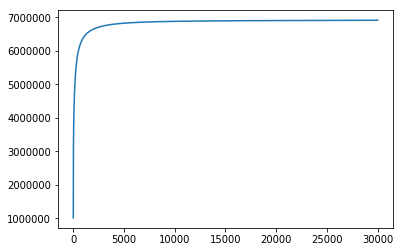

In [8]:
# Create a plot of the frequencies of the tokens to get a sense for VOCAB_SIZE
freqs = [x[1] for x in indexer.freqDist.most_common()]
plt.plot(range(len(freqs)), np.cumsum(freqs))

In [34]:
# Fit and generate indices
VOCAB_SIZE = min(4096, len(freqs))
indexer.fit_on_texts(captions_train, vocab_size=VOCAB_SIZE)
indices_train = indexer.texts_to_indices(captions_train, retokenize=False)
print(indices_train[0])

Done training
Transforming texts
Done transforming
[1, 4, 143, 500, 11, 691, 420, 274, 60, 2]


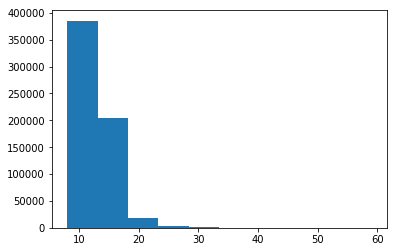

In [35]:
# Plot a histogram of the length of captions to decide padding length
lengths = [len(x) for x in indices_train]
plt.figure()
_ = plt.hist(lengths, bins=10)

In [36]:
# Find maximum caption length
print(max(lengths))

59


In [37]:
# Pad and truncate captions
MAX_SEQ_LEN = 32
X_train = pad_indices(indices_train, maxlen=MAX_SEQ_LEN)
print(X_train[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   1   4 143 500  11 691 420 274  60   2]


In [38]:
# Prepare y train and validation data
y_train = np.concatenate((X_train[:, 1:], np.zeros((len(X_train), 1), dtype='int')), axis=1)  # 0 is padding index
y_train = np.expand_dims(y_train, -1) # for sparse cross entropy training
X_val = indexer.texts_to_indices(captions_val)
X_val = pad_indices(X_val, maxlen=MAX_SEQ_LEN)
y_val = np.concatenate((X_val[:, 1:], np.zeros((len(X_val), 1), dtype='int')), axis=1)
y_val = np.expand_dims(y_val, -1)

Transforming texts
Done transforming


In [39]:
# Hyperparamters for training and inference model
EMBEDDING_DIM = 128
LSTM_NODES = 128
# Build model
model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQ_LEN))
model.add(LSTM(LSTM_NODES, return_sequences=True))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(VOCAB_SIZE, activation='softmax')))
model.summary()
model.compile(loss='sparse_categorical_crossentropy', optimizer='RMSProp', metrics=['accuracy'])

fname = 'model/v2/language_generation-{epoch:02d}-{loss:.2f}.h5'
cbks = [callbacks.ModelCheckpoint(filepath=fname, monitor='loss'),
        callbacks.EarlyStopping(monitor='loss', patience=3)]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 32, 128)           524288    
_________________________________________________________________
lstm_4 (LSTM)                (None, 32, 128)           131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 128)           0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 32, 4096)          528384    
Total params: 1,184,256
Trainable params: 1,184,256
Non-trainable params: 0
_________________________________________________________________


In [15]:
# load previous model and keep training
# model = load_model(fname)
# model.evaluate(X_val, y_val)

In [40]:
start = time.time()
history = model.fit(X_train, y_train, batch_size=32, epochs=128, verbose=1, shuffle=True, 
                    validation_data=(X_val, y_val), callbacks=cbks) 
end = time.time()
print('Takes {}s'.format(end-start))

Train on 611767 samples, validate on 5000 samples
Epoch 1/128
611767/611767 [==============================] - 1041s - loss: 1.4160 - acc: 0.7442 - val_loss: 1.3181 - val_acc: 0.7619
Epoch 2/128
611767/611767 [==============================] - 1035s - loss: 1.2928 - acc: 0.7644 - val_loss: 1.3140 - val_acc: 0.7663
Epoch 3/128
611767/611767 [==============================] - 1038s - loss: 1.3016 - acc: 0.7662 - val_loss: 1.3217 - val_acc: 0.7669
Epoch 4/128
611767/611767 [==============================] - 1037s - loss: 1.3035 - acc: 0.7670 - val_loss: 1.3227 - val_acc: 0.7677
Epoch 5/128
611767/611767 [==============================] - 1037s - loss: 1.2977 - acc: 0.7681 - val_loss: 1.3184 - val_acc: 0.7689
Epoch 6/128
611767/611767 [==============================] - 1035s - loss: 1.2924 - acc: 0.7690 - val_loss: 1.3152 - val_acc: 0.7688
Epoch 7/128
611767/611767 [==============================] - 1036s - loss: 1.2872 - acc: 0.7695 - val_loss: 1.3159 - val_acc: 0.7695
Epoch 8/128
611767/

KeyboardInterrupt: 

In [94]:
fname_current = 'model/v2/language_generation_current.h5'
model.save(fname_current)

In [105]:
model = load_model(fname)

In [106]:
weights_fname = 'model/v2/language_generation_weights.h5'
model.save_weights(weights_fname)

In [107]:
# Build inference model
inference_model = Sequential()
inference_model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=1, batch_input_shape=(1, 1)))
inference_model.add(LSTM(LSTM_NODES, return_sequences=False, stateful=True))
inference_model.add(Dropout(0.2))
inference_model.add(Dense(VOCAB_SIZE, activation='softmax'))
inference_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (1, 1, 128)               524288    
_________________________________________________________________
lstm_7 (LSTM)                (1, 64)                   49408     
_________________________________________________________________
dropout_7 (Dropout)          (1, 64)                   0         
_________________________________________________________________
dense_7 (Dense)              (1, 4096)                 266240    
Total params: 839,936
Trainable params: 839,936
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Load weights from original model
inference_model.load_weights(weights_fname)

In [104]:
# Sample sentences
def sample_sentence(model):
    model.reset_states()
    input_index = np.full((1, 1), indexer.token2index[indexer.start_token])
    sentence = []
    while True:
        next_probs = model.predict(input_index).astype('float64')
        next_probs = next_probs / next_probs.sum()
        next_index = np.random.multinomial(1, next_probs.squeeze()).argmax()
        next_word = indexer.index2token[next_index]
        sentence.append(next_word)
        if next_word == indexer.end_token:
            break
        if next_word in (indexer.unknown_token, indexer.padding_token, indexer.start_token): # Reset and start again if encounter unknown token
            model.reset_states()
            sentence = []
            input_index = np.full((1, 1), indexer.token2index[indexer.start_token])
        else:
            input_index = np.full((1, 1), next_index)
    return sentence
sentences = [sample_sentence(inference_model) for _ in range(5)]
_ = [print(' '.join(sentence)) for sentence in sentences]

having a drink in a parking lot and ramp nearby . END_TOKEN
bench on a toothbrush next to a blue hitting eating man watching the wall next to the wall , computer , passing , lights and buses are waiting to playing the play wii . END_TOKEN
left gray pillow and lights hanging a cutting different older skateboarder . END_TOKEN
a building has a red and them waiting setting to drinking from an and two glasses . END_TOKEN
side view mirror of an birds steel tall buildings in living small of . END_TOKEN


In [99]:
input = np.full((1,1), indexer.token2index['kid'])
inference_model.reset_states()
print(inference_model.predict(input)[:, indexer.token2index['END_TOKEN']])

[ 0.00011383]
